
## LoRA

Resources:

1. Paper: https://arxiv.org/abs/2106.09685
1. Umar Jamil video - https://www.youtube.com/watch?v=PXWYUTMt-AU
2. Sebastian Raschka artcle - https://sebastianraschka.com/blog/2023/llm-finetuning-lora.html





In [1]:
import torch
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
batch_size = 32

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

(3, 122, 242)


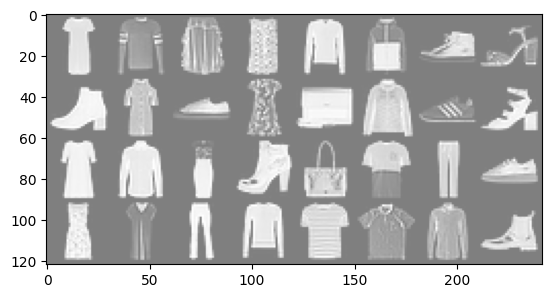

tensor([3, 2, 0, 6, 2, 4, 7, 5, 9, 3, 7, 3, 8, 4, 7, 5, 3, 6, 3, 9, 8, 0, 1, 7,
        3, 3, 1, 2, 0, 0, 6, 9])


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(labels)

## Create an over parameterized neural network

The main intuition behind LoRA is that LLMs are overparametrized and thus not all weights capture unique information, the weights live on a lower dimensional manifold - thus if we want to adapt the weights to a new task, for which we are finetuning the LLM, then the update might also lie on a lower dimensional manifold.

If this hypothesis is true then we should be able to reduce the weight updates, ∆W, into a product of AxB. Where `∆W = AxB` -> `size(∆W) = (m,n)` while `size(A) = (m,r=1)` and `size(B) = (r=1,n)`.

So if we learn A and B we are learning and updating `m + n` weights instead of the full `m x n` weights if the `rank = 1` which often works quite well!

In [4]:
#Create an over parameterized neural network

class FashionNet(nn.Module):
    def __init__(self, hidden_layer_1=1000, hidden_layer_2=2000, hidden_layer_3=1000):
        super(FashionNet, self).__init__()

        self.fc1 = nn.Linear(28*28, hidden_layer_1) # 784 x 1000
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2) # 1000 x 2000
        self.fc3 = nn.Linear(hidden_layer_2, hidden_layer_3) # 2000 x 1000
        self.fc4 = nn.Linear(hidden_layer_3, 10) # 1000 x 10 classes out
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28) #reshape and flatten the image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = FashionNet().to(device)

In [5]:
from torchsummary import summary

summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]         785,000
              ReLU-2                 [-1, 1000]               0
            Linear-3                 [-1, 2000]       2,002,000
              ReLU-4                 [-1, 2000]               0
            Linear-5                 [-1, 1000]       2,001,000
              ReLU-6                 [-1, 1000]               0
            Linear-7                   [-1, 10]          10,010
Total params: 4,798,010
Trainable params: 4,798,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 18.30
Estimated Total Size (MB): 18.37
----------------------------------------------------------------


In [6]:
total_parameters_original = 0
for index, layer in enumerate([net.fc1, net.fc2, net.fc3, net.fc4]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([1000, 2000]) + B: torch.Size([1000])
Layer 4: W: torch.Size([10, 1000]) + B: torch.Size([10])
Total number of parameters: 4,798,010


In [8]:
def train(train_loader, model, epochs=10, max_iter=None):
    crossEL = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        net.train()

        loss_total = 0
        num_iterations = 0

        data_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}')

        for data in data_iter:
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs.view(-1, 28*28))

            loss = crossEL(outputs, labels)
            loss_total += loss.item()
            num_iterations += 1
            avg_loss = loss_total/num_iterations
            data_iter.set_postfix(loss=avg_loss)

            loss.backward()
            optimizer.step()

            if max_iter is not None and num_iterations >= max_iter:
                return

        print(f'Epoch {epoch+1} loss: {loss_total/num_iterations}')

train(train_loader, net, epochs=1)

In [9]:
label_dict = {0:'T-shirt/top',
              1:'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}

def test():
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x.view(-1,28*28))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for item {i} - {label_dict[i]}: {wrong_counts[i]}')

test()

Testing: 100%|██████████| 313/313 [00:05<00:00, 54.47it/s]

Accuracy: 0.84
wrong counts for item 0 - T-shirt/top: 140
wrong counts for item 1 - Trouser: 44
wrong counts for item 2 - Pullover: 256
wrong counts for item 3 - Dress: 78
wrong counts for item 4 - Coat: 405
wrong counts for item 5 - Sandal: 97
wrong counts for item 6 - Shirt: 448
wrong counts for item 7 - Sneaker: 34
wrong counts for item 8 - Bag: 37
wrong counts for item 9 - Ankle boot: 62


## We get the worse performance on coats[4], shirts[6] and pullovers[2] lets LoRA finetune on these categories.

In [10]:
original_weights = {}
for name, param in net.named_parameters():
    print(name, param.shape)
    original_weights[name] = param.clone().detach()

fc1.weight torch.Size([1000, 784])
fc1.bias torch.Size([1000])
fc2.weight torch.Size([2000, 1000])
fc2.bias torch.Size([2000])
fc3.weight torch.Size([1000, 2000])
fc3.bias torch.Size([1000])
fc4.weight torch.Size([10, 1000])
fc4.bias torch.Size([10])


In [11]:
class LoRAAdaption(nn.Module):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device='cpu'):
        super().__init__()
        # Section 4.1 of the paper:
        #   We use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training
        self.lora_A = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((rank, features_out)).to(device))

        nn.init.normal_(self.lora_A, mean=0, std=1)

        # Section 4.1 of the paper:
        #   We then scale ∆Wx by α/r , where α is a constant in r.
        #   When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately.
        #   As a result, we simply set α to the first r we try and do not tune it.
        #   This scaling helps to reduce the need to retune hyperparameters when we vary r.
        self.scale = alpha / rank
        self.lora = True

    def forward(self, original_weights):
        if self.lora:
            # Return W + (A*B)*scale
            return original_weights + torch.matmul(self.lora_A, self.lora_B).view(original_weights.shape) * self.scale
        else:
            return original_weights


In [12]:
import torch.nn.utils.parametrize as parametrize

def fc_parametrize(layer, device, rank=1, alpha=1):
    return LoRAAdaption(layer.weight.shape[0], layer.weight.shape[1], rank=rank, alpha=alpha, device=device)

parametrize.register_parametrization(net.fc1, 'weight', fc_parametrize(net.fc1, device))

parametrize.register_parametrization(net.fc2, 'weight', fc_parametrize(net.fc2, device))

parametrize.register_parametrization(net.fc3, 'weight', fc_parametrize(net.fc3, device))

parametrize.register_parametrization(net.fc4, 'weight', fc_parametrize(net.fc4, device))

def enable_lora(enabled=True):
    for layer in [net.fc1, net.fc2, net.fc3, net.fc4]:
        layer.parametrizations['weight'][0].lora = enabled

In [13]:
total_lora_params = 0
total_params = 0

for index, layer in enumerate([net.fc1, net.fc2, net.fc3, net.fc4]):
    total_params += layer.weight.nelement() + layer.bias.nelement()
    total_lora_params += layer.parametrizations['weight'][0].lora_A.nelement() + layer.parametrizations['weight'][0].lora_B.nelement()

    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
    print(f'Layer {index+1}: A: {layer.parametrizations["weight"][0].lora_A.shape} + B: {layer.parametrizations["weight"][0].lora_B.shape}')

assert total_params == total_parameters_original
print(f'Total number of parameters: {total_params:,}')
print(20*'=')
print(f'Total number of LoRA parameters: {total_lora_params:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 1: A: torch.Size([1000, 1]) + B: torch.Size([1, 784])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 2: A: torch.Size([2000, 1]) + B: torch.Size([1, 1000])
Layer 3: W: torch.Size([1000, 2000]) + B: torch.Size([1000])
Layer 3: A: torch.Size([1000, 1]) + B: torch.Size([1, 2000])
Layer 4: W: torch.Size([10, 1000]) + B: torch.Size([10])
Layer 4: A: torch.Size([10, 1]) + B: torch.Size([1, 1000])
Total number of parameters: 4,798,010
Total number of LoRA parameters: 8,794


In [14]:
parameters_increment = (total_lora_params)/(total_params)*100
print(f'Percentage weights updated: {parameters_increment:.3f}%')

Percentage weights updated: 0.183%


In [15]:
for name, layer in net.named_parameters():
    if 'lora' not in name:
        print(f'Freeze non-LoRA parameters: {name}')
        layer.requires_grad = False

Freeze non-LoRA parameters: fc1.bias
Freeze non-LoRA parameters: fc1.parametrizations.weight.original
Freeze non-LoRA parameters: fc2.bias
Freeze non-LoRA parameters: fc2.parametrizations.weight.original
Freeze non-LoRA parameters: fc3.bias
Freeze non-LoRA parameters: fc3.parametrizations.weight.original
Freeze non-LoRA parameters: fc4.bias
Freeze non-LoRA parameters: fc4.parametrizations.weight.original


## Finetune on Category 4 = Coats, 6 = Shirt, 2 = Pullover

In [41]:
finetune_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

include_index = [target in {2, 4, 6} for i, (_, target) in enumerate(finetune_set)]
finetune_set.data = finetune_set.data[include_index]
finetune_set.targets = finetune_set.targets[include_index]

finetune_loader = torch.utils.data.DataLoader(finetune_set, batch_size=10, shuffle=True)

train(finetune_loader, net, epochs=1,  max_iter=150)

Epoch 1:   8%|▊         | 149/1800 [00:07<01:18, 21.05it/s, loss=0.643]


In [47]:
def lora_tune(model, category_set, iter_batch_max = 50):
    finetune_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

    include_index = [target in category_set for i, (_, target) in enumerate(finetune_set)]
    finetune_set.data = finetune_set.data[include_index]
    finetune_set.targets = finetune_set.targets[include_index]

    finetune_loader = torch.utils.data.DataLoader(finetune_set, batch_size=10, shuffle=True)

    train(finetune_loader, model, epochs=1,  max_iter=iter_batch_max)

    return

In [42]:
#Orginal weights do no change in LoRA finetuning - they are frozen

assert torch.all(net.fc1.parametrizations.weight.original == original_weights['fc1.weight'])
assert torch.all(net.fc2.parametrizations.weight.original == original_weights['fc2.weight'])
assert torch.all(net.fc3.parametrizations.weight.original == original_weights['fc3.weight'])
assert torch.all(net.fc4.parametrizations.weight.original == original_weights['fc4.weight'])

In [43]:
enable_lora(enabled=False)

assert torch.equal(net.fc1.weight, original_weights['fc1.weight'])

In [44]:
enable_lora(enabled=True)

assert torch.equal(net.fc1.weight, net.fc1.parametrizations.weight.original + (net.fc1.parametrizations.weight[0].lora_A @ net.fc1.parametrizations.weight[0].lora_B) * net.fc1.parametrizations.weight[0].scale)
assert torch.equal(net.fc3.weight, net.fc3.parametrizations.weight.original + (net.fc3.parametrizations.weight[0].lora_A @ net.fc3.parametrizations.weight[0].lora_B) * net.fc3.parametrizations.weight[0].scale)

In [45]:
#Same as before
enable_lora(enabled=False)
test()

Testing: 100%|██████████| 313/313 [00:05<00:00, 60.72it/s]

Accuracy: 0.84
wrong counts for item 0 - T-shirt/top: 140
wrong counts for item 1 - Trouser: 44
wrong counts for item 2 - Pullover: 256
wrong counts for item 3 - Dress: 78
wrong counts for item 4 - Coat: 405
wrong counts for item 5 - Sandal: 97
wrong counts for item 6 - Shirt: 448
wrong counts for item 7 - Sneaker: 34
wrong counts for item 8 - Bag: 37
wrong counts for item 9 - Ankle boot: 62


In [46]:
#LoRA Adaption enabled
enable_lora(enabled=True)
test()

Testing: 100%|██████████| 313/313 [00:09<00:00, 32.87it/s]

Accuracy: 0.769
wrong counts for item 0 - T-shirt/top: 1000
wrong counts for item 1 - Trouser: 95
wrong counts for item 2 - Pullover: 293
wrong counts for item 3 - Dress: 291
wrong counts for item 4 - Coat: 220
wrong counts for item 5 - Sandal: 73
wrong counts for item 6 - Shirt: 172
wrong counts for item 7 - Sneaker: 28
wrong counts for item 8 - Bag: 52
wrong counts for item 9 - Ankle boot: 83


In [48]:
lora_tune(net, {2,4,6}, iter_batch_max=200)
enable_lora(enabled=True)
test()

Testing: 100%|██████████| 313/313 [00:08<00:00, 38.39it/s]

Accuracy: 0.725
wrong counts for item 0 - T-shirt/top: 1000
wrong counts for item 1 - Trouser: 147
wrong counts for item 2 - Pullover: 263
wrong counts for item 3 - Dress: 691
wrong counts for item 4 - Coat: 252
wrong counts for item 5 - Sandal: 66
wrong counts for item 6 - Shirt: 164
wrong counts for item 7 - Sneaker: 37
wrong counts for item 8 - Bag: 68
wrong counts for item 9 - Ankle boot: 66
